<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/code/Evaluate_Concreteness_and_Similarity_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ColabFiles/

Mounted at /content/drive/
/content/drive/MyDrive/ColabFiles


In [49]:
# import clics and frequency/concreteness data

clics_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/clics-colexification-data.csv')
source_vars_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/source_vars_df.csv') # frequency/concreteness data

# semantic shift data -- filtered as described in raymond's paper, and grouped by the (source, target) pair
# for derivation, see https://github.com/o-fugi/FURSPColexification/blob/de3b05e4f1ddec5c49ff8fe6794b870a4e0b60fc/code/Predict_Source_Probability_with_Frequency_and_Concreteness.ipynb?short_path=4ec278e#L178-L190
sem_shift_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/filtered_dat_sem_shift.csv')

In [4]:
# install sentence-trasnformers
%%capture
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('whaleloops/phrase-bert')

In [5]:
# define how we map a sense to concreteness

skip_words = {'the', 'an', 'a', 'of','in', 'it', 'to', 'for', 'on', 'in'} # don't factor these into concreteness

# take all words in the sense and and average concreteness (matches most entries in CLICS/DatSemShift, so less conservative)
def senseToConc(s):
  s = s.lower()
  for i in "(),/":
    s = s.replace(i, "")
  phrases = re.split(' ', s)
  total_conc = 0
  conc_data = 0
  for p in phrases:
    if p in skip_words:
      continue
    try:
      conc = source_vars_df[source_vars_df['Word']==p]['Conc'].values[0]
      if not np.isnan(conc):
        total_conc += conc
        conc_data += 1
    except:
      pass
  if conc_data == 0:
    total_conc = np.nan
  else:
    total_conc /= conc_data
  return total_conc

# only average concreteness of phrases separated by commas or slashes (matches fewer entries in CLICS/DatSemShift, so more conservative)
def senseToConc_Conservative(s):
  s = s.lower()
  phrases = re.split('/|,', s)
  total_conc = 0
  conc_data = 0
  for p in phrases:
    p = p.strip()
    if (len(p.split(' ')) > 1) & (p.split(' ')[0] == 'to'):
      p = re.sub("^to ", "", p)
    try:
      conc = source_vars_df[source_vars_df['Word']==p]['Conc'].values[0]
      if not np.isnan(conc):
        total_conc += conc
        conc_data += 1
    except:
      pass
  if conc_data == 0:
    total_conc = np.nan
  else:
    total_conc /= conc_data
  return total_conc

In [ ]:
#@title
# pickle load dictionary for conreteness and embeddings to save like 7 minutes of loading 
# import pickle

# conc_dic = pickle.load(open('conc_dic.p', 'rb'))
# vec_dic = pickle.load(open('vec_dic.p', 'rb'))

In [6]:
# dictionary for concreteness and embeddings
conc_dic = {} # This will be a dictionary that easily allows us to access the concreteness for all of our senses, saving time. 
vec_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings or concreteness values

for i in range(len(clics_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = clics_df.iloc[i]
  x = row["Concepticon_Gloss.xo"]
  y = row["Concepticon_Gloss.yo"]

  try:   
    if x not in vec_dic:
      xvec = np.array(model.encode(x))
      vec_dic[x] = xvec
  except:
    error_senses.add(x)

  try:  
    if y not in vec_dic:
      yvec = np.array(model.encode(y))
      vec_dic[y] = yvec
  except: 
    error_senses.add(y)

  if x not in conc_dic:
    x_conc = senseToConc_Conservative(x)
    if not np.isnan(x_conc):
      conc_dic[x] = x_conc
    else:
      error_senses.add(x)

  if y not in conc_dic:
    y_conc = senseToConc_Conservative(y)
    if not np.isnan(y_conc):
      conc_dic[y] = y_conc
    else:
      error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [7]:
# get p(s_i)

conc_df = pd.DataFrame.from_dict(conc_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'conc'})
all_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='Concepticon_Gloss.xo',right_on='Word', how='left'), [clics_df, conc_df])
all_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='Concepticon_Gloss.yo',right_on='Word', how='left'), [all_vars_df, conc_df])
all_vars_df['prior'] = all_vars_df[['conc_x', 'conc_y']].max(axis=1)
all_vars_df['reverse_prior'] = all_vars_df[['conc_x', 'conc_y']].min(axis=1)

In [8]:
# get f(s_i, s_j)

def getEmbedding(s):
  return vec_dic[s]

def getSim(vec):
  x = vec[0]
  y = vec[1]
  return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

all_vars_df['v1'] = all_vars_df['Concepticon_Gloss.xo'].apply(getEmbedding)
all_vars_df['v2'] = all_vars_df['Concepticon_Gloss.yo'].apply(getEmbedding)
all_vars_df['sim'] = all_vars_df[['v1', 'v2']].apply(getSim, axis=1)

In [9]:
# print('Spearman correlation for colex and similarity:', all_vars_df.corr()['sim']['colex.freq']) # verified by Cognition paper
# print('Spearman correlation for colex and prior:', all_vars_df.corr()['prior']['colex.freq']) # almost zero
# print('Spearman correlation for colex and reverse prior:', all_vars_df.corr()['reverse_prior']['colex.freq']) # almost zero

Spearman correlation for colex and similarity: 0.21034262853971106
Spearman correlation for colex and prior: -0.007540992767816256
Spearman correlation for colex and reverse prior: 0.030254682385826428


In [42]:
# linear regression to get coefficients

filtered_vars_df = all_vars_df[~np.isnan(all_vars_df['sim']) & ~np.isnan(all_vars_df['prior'])].copy()
filtered_vars_df = filtered_vars_df[~np.isnan(filtered_vars_df['conc_x']) & ~np.isnan(filtered_vars_df['conc_y'])]

# just take more frequently correlated cases
# filtered_vars_df = filtered_vars_df[filtered_vars_df['colex.freq'] > 2]

filtered_vars_df['log_prior'] = np.log(filtered_vars_df['prior'])
filtered_vars_df['log_sim'] = np.log(filtered_vars_df['sim'])
filtered_vars_df['log_colex'] = np.log(filtered_vars_df['colex.freq'])
filtered_vars_df['log_reverse_prior'] = np.log(filtered_vars_df['reverse_prior'])

X = filtered_vars_df[['log_prior', 'log_sim', 'prior', 'sim', 'log_reverse_prior']]#.values.reshape(-1, 5)  
Y = filtered_vars_df[['log_colex', 'colex.freq']]#.values.reshape(-1, 2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

X_train_vars = X_train[['log_prior', 'log_sim']].values.reshape(-1, 2)
Y_train_vars = Y_train[['log_colex']].values.reshape(-1, 1)

lin_reg = LinearRegression().fit(X_train_vars, Y_train_vars)

# test on held-out data
results_df = pd.DataFrame()
results_df['log_prior'] = X_test['log_prior'] 
results_df['log_sim'] = X_test['log_sim']
results_df['prior'] = X_test['prior']
results_df['sim'] = X_test['sim'] 
results_df['log_colex'] = Y_test['log_colex'] 
results_df['colex.freq'] = Y_test['colex.freq'] 
results_df['lin_reg_predict'] = lin_reg.predict(X_test[['log_prior', 'log_sim']].values.reshape(-1, 2))

In [43]:
print('Spearman correlation for colex and similarity:', results_df.corr()['sim']['colex.freq']) # 
print('Spearman correlation for colex and similarity:', results_df.corr()['prior']['colex.freq']) # 

print('Spearman correlation for log colex and log similarity:', results_df.corr()['log_sim']['log_colex']) # 
print('Spearman correlation for log colex and log prior:', results_df.corr()['log_prior']['log_colex']) # almost 0

print('Spearman correlation for log colex and log similarity + log concreteness:', results_df.corr()['lin_reg_predict']['log_colex']) 

Spearman correlation for colex and similarity: 0.18792126232233994
Spearman correlation for colex and similarity: -0.024912800341047116
Spearman correlation for log colex and log similarity: 0.2773296814356593
Spearman correlation for log colex and log prior: -0.07352012433338015
Spearman correlation for log colex and log similarity + log concreteness: 0.284362066110771


In [44]:
X_train_vars = X_train[['log_reverse_prior', 'log_sim']].values.reshape(-1, 2)
Y_train_vars = Y_train[['log_colex']].values.reshape(-1, 1)

lin_reg_r = LinearRegression().fit(X_train_vars, Y_train_vars)

# test on held-out data
results_df['lin_reg_predict_r'] = lin_reg.predict(X_test[['log_reverse_prior', 'log_sim']])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [45]:
print('Spearman correlation for log colex and log similarity + log reverse concreteness:', results_df.corr()['lin_reg_predict_r']['log_colex']) 

Spearman correlation for log colex and log similarity + log reverse concreteness: 0.27131508923334724


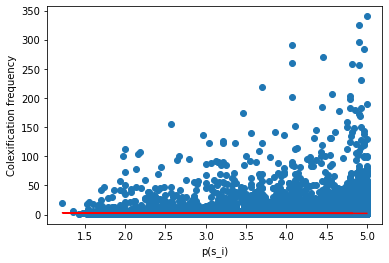

In [ ]:
#@title plot showing that p(s_i) could conceivably be correlated with concreteness

# X = filtered_vars_df[['prior']].values.reshape(-1, 1)  
# Y = filtered_vars_df[['colex.freq']].values.reshape(-1, 1)
# lin_reg_conc = LinearRegression().fit(X, Y)
# filtered_vars_df['lin_reg_predict_prior'] = lin_reg_conc.predict(X)

# plt.xlabel("p(s_i)")
# plt.ylabel("Colexification frequency")
# plt.scatter(filtered_vars_df['prior'], Y)
# plt.plot(filtered_vars_df['prior'], filtered_vars_df['lin_reg_predict_prior'], c='red')
# plt.show()

# Test prior accuracy
with senseToConc, accuracy is 66%

with senseToConc_Conservative, accuracy is 74%

note that neither concreteness measure improves the Spearman correlation 


In [48]:
# filter semshift by realizations > 1 
# sem_shift_df = sem_shift_df[sem_shift_df['realizations'] > 1]

In [50]:
# get priors for semshift data

# dictionary for concreteness and embeddings
conc_dic = {} # This will be a dictionary that easily allows us to access the concreteness for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings. 

for i in range(len(sem_shift_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = sem_shift_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  if x not in conc_dic:
    x_conc = senseToConc_Conservative(x)
    if not np.isnan(x_conc):
      conc_dic[x] = x_conc
    else:
      error_senses.add(x)

  if y not in conc_dic:
    y_conc = senseToConc_Conservative(y)
    if not np.isnan(y_conc):
      conc_dic[y] = y_conc
    else:
      error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [51]:
# test prior accuracy

# merge concreteness with shift df
conc_df = pd.DataFrame.from_dict(conc_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'conc'})
shift_conc_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df, conc_df])
shift_conc_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_conc_df, conc_df])

# calculate ratio and find accuracy
shift_conc_df['ratio'] = shift_conc_df['conc_x'] / shift_conc_df['conc_y']
shift_conc_df = shift_conc_df[~np.isnan(shift_conc_df['ratio'])]
shift_conc_df['ratio_accurate'] = shift_conc_df['ratio'] > 1
print(shift_conc_df['ratio_accurate'].value_counts())
print("accuracy: ", shift_conc_df['ratio_accurate'].value_counts()[True] / len(shift_conc_df))

True     1088
False     402
Name: ratio_accurate, dtype: int64
accuracy:  0.7302013422818792


## Test frequency as well, for the write-up

In [62]:
# define how we map a sense to frequency

skip_words = {'the', 'an', 'a', 'of','in', 'it', 'to', 'for', 'on', 'in'} # don't factor these into frequency

# take all words in the sense and and average frequency (matches most entries in CLICS/DatSemShift, so less conservative)
def senseToFreq(s):
  s = s.lower()
  for i in "(),/":
    s = s.replace(i, "")
  phrases = re.split(' ', s)
  total_freq = 0
  freq_data = 0
  for p in phrases:
    if p in skip_words:
      continue
    try:
      freq = source_vars_df[source_vars_df['Word']==p]['Freq'].values[0]
      if not np.isnan(freq):
        total_freq += freq
        freq_data += 1
    except:
      pass
  if freq_data == 0:
    total_freq = np.nan
  else:
    total_freq /= freq_data
  return total_freq

# ADD frequency of phrases separated by commas or slashes (matches fewer entries in CLICS/DatSemShift, so more conservative)
def senseToFreq_Conservative(s):
  s = s.lower()
  phrases = re.split('/|,', s)
  total_freq = 0
  freq_data = 0
  for p in phrases:
    p = p.strip()
    if (len(p.split(' ')) > 1) & (p.split(' ')[0] == 'to'):
      p = re.sub("^to ", "", p)
    try:
      freq = source_vars_df[source_vars_df['Word']==p]['Freq'].values[0]
      if not np.isnan(freq):
        total_freq += freq
        freq_data += 1
    except:
      pass
  if freq_data == 0:
    total_freq = np.nan
  return total_freq

In [67]:
# get priors for semshift data

# dictionary for frequency and embeddings
freq_dic = {} # This will be a dictionary that easily allows us to access the frequency for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings. 

for i in range(len(sem_shift_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = sem_shift_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  if x not in freq_dic:
    x_freq = senseToFreq_Conservative(x)
    if not np.isnan(x_freq):
      freq_dic[x] = x_freq
    else:
      error_senses.add(x)

  if y not in freq_dic:
    y_freq = senseToFreq_Conservative(y)
    if not np.isnan(y_freq):
      freq_dic[y] = y_freq
    else:
      error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [69]:
# test prior accuracy

# merge frequency with shift df
freq_df = pd.DataFrame.from_dict(freq_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'freq'})
shift_freq_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df, freq_df])
shift_freq_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_freq_df, freq_df])

# calculate ratio and find accuracy
shift_freq_df['ratio'] = shift_freq_df['freq_x'] / shift_freq_df['freq_y']
shift_freq_df = shift_freq_df[~np.isnan(shift_freq_df['ratio'])]
shift_freq_df['ratio_accurate'] = shift_freq_df['ratio'] > 1
print(shift_freq_df['ratio_accurate'].value_counts())
print("accuracy: ", shift_freq_df['ratio_accurate'].value_counts()[True] / len(shift_freq_df))

True     821
False    615
Name: ratio_accurate, dtype: int64
accuracy:  0.5717270194986073
